# Emulate FATES

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_rows', 500)

## Functions

In [25]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

## Import data

In [2]:
raw_df = pd.read_csv('all_member_output_101223.csv')
raw_df.info()
print("\n")

# Drop first column
raw_df.drop(columns=raw_df.columns[0], axis=1, inplace=True)
print(list(raw_df.columns))

df = raw_df.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Columns: 117 entries, Unnamed: 0 to case_tag
dtypes: float64(113), int64(4)
memory usage: 2.7 MB


['BA', 'AGB', 'TreeStemD', 'ResproutD_oak', 'ResproutD_shrub', 'ShannonE', 'NPP', 'FailedPFTs', 'Pct_shrub_cover_canopy', 'Pct_shrub_cover', 'Combustible_fuel', 'BA_pine', 'BA_cedar', 'BA_fir', 'BA_shrub', 'BA_oak', 'inst', 'fates_recruit_seed_alloc_mature_1', 'fates_recruit_seed_alloc_mature_2', 'fates_recruit_seed_alloc_mature_3', 'fates_recruit_seed_alloc_mature_4', 'fates_recruit_seed_alloc_mature_5', 'fates_recruit_seed_dbh_repro_threshold_1', 'fates_recruit_seed_dbh_repro_threshold_2', 'fates_recruit_seed_dbh_repro_threshold_3', 'fates_recruit_seed_dbh_repro_threshold_5', 'fates_fire_alpha_SH_1', 'fates_fire_alpha_SH_2', 'fates_fire_alpha_SH_3', 'fates_fire_alpha_SH_4', 'fates_fire_alpha_SH_5', 'fates_fire_bark_scaler_1', 'fates_fire_bark_scaler_2', 'fates_fire_bark_scaler_3', 'fates_fire_bark_scaler_4', 'fate

## Clean

In [3]:
df.fillna(0, inplace=True)

## Add coexistence variable

We define coexistence as runs where there were no failed pfts.

A failed pft is defined as one that had basal area [m2 ha-1] < 0.1

The goal of the emulator is to increase the success rate of coexistence.

In [4]:
df['coexistence'] = df['FailedPFTs'] == 0
coex_table = df['coexistence'].value_counts()

print("\n")

print('Coexistence success rate:',coex_table[1]/coex_table[0] * 100, "%")



Coexistence success rate: 6.403940886699508 %


## Split data into train and test sets

While ensuring that the train and test sets have equal ratios of coexistence to non-coexistence

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size = 0.1, random_state = 42)

# Split the data into training and test sets, maintaining an equal proportion of veg and non-veg labels in each.
for train_index, test_index in split.split(df, df['coexistence']):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]
    
X_cols = train_set.columns[train_set.columns.str.contains('fates')]
train_X = train_set[X_cols]
test_X = test_set[X_cols]

#Create vars to be predicted
train_y_coex = train_set["coexistence"].copy()
train_y_shannonE = train_set["ShannonE"].copy()
train_y_failedPFTs = train_set["FailedPFTs"].copy()

test_Y_coex = test_set["coexistence"].copy()
test_y_shannonE = test_set["ShannonE"].copy()
test_y_failedPFTs = test_set["FailedPFTs"].copy()

### Check that the train and test sets have similar ratios of coexistence to competitive exclusion

In [19]:
print("train:",train_y_coex.value_counts())
print("test:",test_set['coexistence'].value_counts())

train: False    2557
True      164
Name: coexistence, dtype: int64
test: False    285
True      18
Name: coexistence, dtype: int64


## Set up a data transformation pipeline to prepare the data for machine learning


Here we standardize the data, but some algorithms (some neural networks), need normalized data 0-1.
Normalizing can make outliers have a big effect on the data though ("squishing down"), so removing outliers can be helpful before normalizing.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# This is for if I need to define a custom data transformation function
from sklearn.base import BaseEstimator, TransformerMixin


# Data transformation pipeline
transformation_pipeline = Pipeline([
        ('std_scaler', StandardScaler()), # Scale the data by substracting mean and dividing by sigma
    ])

# Apply transformation pipeline to training data
X = transformation_pipeline.fit_transform(train_X)

## Define a naive classifier to compare our classifiers to

This classifier always predicts no coexistence.

In [21]:
from sklearn.base import BaseEstimator
class NeverCoexist(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        
        #always predicts false (0)
        return np.zeros((len(X), 1), dtype=bool)

In [23]:
# Naive classifier
never_coexist = NeverCoexist()
# test naive classifier
naive_scores = cross_val_score(never_coexist, X, train_y_coex, cv= 10, scoring="accuracy")
print("Naive:",naive_scores)

Naive: [0.91941392 0.97058824 0.94485294 0.92279412 0.91544118 0.94485294
 0.95220588 0.94852941 0.91911765 0.95955882]


# Emulate coexistence

## Decision Tree

Decision tree performs worse that the naive classifier

In [8]:
from sklearn.tree import DecisionTreeClassifier


# Naive classifier
never_coexist = NeverCoexist()

# decision tree classifier
tree = DecisionTreeClassifier()


# test regression tree
tree_scores = cross_val_score(tree, X, train_y_coex, cv= 10, scoring="accuracy")
print("Decision Tree:",tree_scores)

Naive: [0.91941392 0.97058824 0.94485294 0.92279412 0.91544118 0.94485294
 0.95220588 0.94852941 0.91911765 0.95955882]
Decision Tree: [0.8974359  0.88602941 0.90073529 0.87132353 0.90073529 0.86397059
 0.89705882 0.87132353 0.88970588 0.87132353]


## Random Forest to predict coexistence

In [19]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=100,max_features=0.25)

forest_scores = cross_val_score(forest,X,train_y_coex,cv=10,scoring="accuracy")

NameError: name 'naive_scores' is not defined

In [28]:
#forest.get_params()

In [27]:
print("Naive:")
print(display_scores(naive_scores))
print("\n")
print("Forest")
print(display_scores(forest_scores))

Naive:
Scores: [0.91941392 0.97058824 0.94485294 0.92279412 0.91544118 0.94485294
 0.95220588 0.94852941 0.91911765 0.95955882]
Mean: 0.9397355095884506
Standard deviation: 0.018290331458515947
None


Forest
Scores: [0.93772894 0.94117647 0.94117647 0.94117647 0.94117647 0.94117647
 0.94117647 0.9375     0.9375     0.9375    ]
Mean: 0.9397287761258349
Standard deviation: 0.001774164541686241
None


In [29]:
forest = RandomForestClassifier(n_estimators=100,max_features=0.25)

forest_preds = cross_val_predict(forest,X,train_y_coex,cv=3)

### Confusion matrix

The RF model almost never predicts coexistence

In [30]:
confusion_matrix(train_y_coex,forest_preds)

array([[2556,    1],
       [ 164,    0]])

### Find optimal hyperparams with grid search

In [16]:
#Here we use the GridSearchCV function to find optimal hyperparameters

#However, we can also use RandomizedSearchCV where you can specify the
#Number of iterations directly and pull from (I guess) a distribution of hyperparameters

# from sklearn.model_selection import GridSearchCV

# param_grid = [
#     {'n_estimators': [35, 100, 500], 'max_features': [0.25, 0.5, 0.8]},
#     {'bootstrap': [False], 'n_estimators': [35, 100, 500], 'max_features': [0.25, 0.5, 0.8]},
#   ]

# forest_grid = RandomForestClassifier()

# # train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
# grid_search = GridSearchCV(forest_grid, param_grid, cv=5,
#                            scoring='accuracy',
#                            return_train_score=True)
# grid_search.fit(X, train_y_coex)
# grid_search.best_params_

{'max_features': 0.25, 'n_estimators': 100}

## See results of the hyperparameter optimization

Scores are not very sensitive to these hyperparameters, but best had these params:{'max_features': 0.25, 'n_estimators': 100}

In [34]:
# cvres = grid_search.cv_results_
# for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
#     print(mean_score,params)

0.9393604964921749 {'max_features': 0.25, 'n_estimators': 35}
0.9397281435509983 {'max_features': 0.25, 'n_estimators': 100}
0.9397281435509983 {'max_features': 0.25, 'n_estimators': 500}
0.9375236103615758 {'max_features': 0.5, 'n_estimators': 35}
0.9389928494333514 {'max_features': 0.5, 'n_estimators': 100}
0.9393604964921749 {'max_features': 0.5, 'n_estimators': 500}
0.9389935240151106 {'max_features': 0.8, 'n_estimators': 35}
0.9393604964921749 {'max_features': 0.8, 'n_estimators': 100}
0.9386252023745278 {'max_features': 0.8, 'n_estimators': 500}
0.9386252023745278 {'bootstrap': False, 'max_features': 0.25, 'n_estimators': 35}
0.9393604964921749 {'bootstrap': False, 'max_features': 0.25, 'n_estimators': 100}
0.9393604964921749 {'bootstrap': False, 'max_features': 0.25, 'n_estimators': 500}
0.9353170534268752 {'bootstrap': False, 'max_features': 0.5, 'n_estimators': 35}
0.9338478143550997 {'bootstrap': False, 'max_features': 0.5, 'n_estimators': 100}
0.9367869670804101 {'bootstrap'

## Look at feature importances

In [36]:
# feature_importances = grid_search.best_estimator_.feature_importances_
# fi = pd.DataFrame(np.column_stack([X_cols,feature_importances]),columns=["param","feature_importance"])
# fi.sort_values("feature_importance",ascending=False)

,param,feature_importance
35,fates_leaf_slatop_4,0.031417
36,fates_leaf_slatop_5,0.02267
25,fates_fire_nignitions_0,0.021328
53,fates_frag_seed_decay_rate_4,0.018179
3,fates_recruit_seed_alloc_mature_4,0.017352
42,fates_leaf_vcmax25top_5,0.016985
73,fates_nonhydro_smpsc_3,0.016274
77,fates_recruit_inter_patch_disp_frac_0,0.016268
84,fates_stoich_nitr_4,0.015925
97,fates_allom_agb1_5,0.015827


### Look at precision vs. recall tradeoff

In [ ]:
pick up here

## Support Vector Machine

In [11]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_scores = cross_val_score(svm_clf,X,train_y_coex,cv=10,scoring="accuracy")
print("Naive:",naive_scores)
print("\n")
print("SVM:",svm_scores)

SVM: [0.93772894 0.94117647 0.94117647 0.94117647 0.94117647 0.94117647
 0.94117647 0.9375     0.9375     0.9375    ]


### Find optimal hyper parameters for support vector machine

## Stochastic Gradient Descent Classifier

This is crashing the kernel

In [10]:
# from sklearn.linear_model import SGDClassifier

# sgd_clf = SGDClassifier(random_state=42)

# sgd_scores = cross_val_score(sgd_clf,X,train_y_coex,cv=10,scoring="accuracy")

# print("Naive:",naive_scores)
# print("\n")
# print("SGD:",sgd_scores_scores)

## Make confusion matrices of optimized naive, random forest, and svm

In [ ]:
# Pick up here with looking at precision / recall tradeoff for optimized RF algorithm.
# Then choose what the proba threshold value should be

## Analyze precision recall tradeoff curves for random forest and svm

Find a score that makes sense for this case. Recall can be bad.

## Build a regressor model to predict shannon's equitability index

Perhaps by combining the predictions of these models we can get a better sense of which param sets should be successful.

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [21]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()

forest_reg_scores = cross_val_score(forest_reg,X,train_y_shannonE,cv=10,scoring="neg_mean_squared_error")
print("Forest:",forest_reg_scores)

Forest: [-0.04440195 -0.03881893 -0.04175252 -0.04526501 -0.04008802 -0.03440066
 -0.03874263 -0.0387484  -0.04124436 -0.033361  ]


In [26]:
tree_reg_rmse_scores = np.sqrt(-forest_reg_scores)
print(tree_reg_rmse_scores)
print("Mean RMSE:",tree_reg_rmse_scores.mean())

[0.21071769 0.19702521 0.20433433 0.21275575 0.20021992 0.18547415
 0.19683148 0.19684613 0.20308708 0.18264994]
Mean RMSE 0.1989941671712163


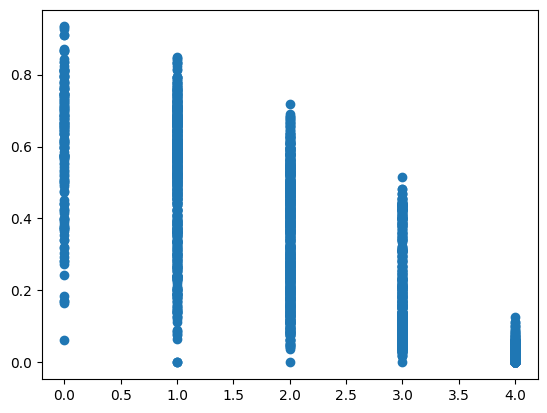

In [6]:
plt.scatter(train_set['FailedPFTs'],train_set['ShannonE'])

## Build random forest model to predict the number of failed pfts (instead of just binary)

It should be better at doing this because it will have more data. It might still confuse cases where 1 or 0 pfts fail, but it would still be useful to rule out cases where >1 pfts fail and it might be able to do a good job of this.

In [14]:
from sklearn.ensemble import RandomForestClassifier

forest_failedPFTs = RandomForestClassifier()

forest_failedPFTs_scores = cross_val_score(forest_failedPFTs,X,train_y_failedPFTs,cv=10,scoring="accuracy")

print("Forest:",forest_failedPFTs_scores)

Forest: [0.43589744 0.44852941 0.51470588 0.46691176 0.45220588 0.47426471
 0.48897059 0.41911765 0.48529412 0.48161765]


In [15]:


y_pred_failedPFTs = cross_val_predict(forest_failedPFTs,X,train_y_failedPFTs)
confusion_matrix(train_y_failedPFTs,y_pred_failedPFTs)

array([[  0,  72,  66,   5,  21],
       [  0, 261, 266,  15,  95],
       [  0, 181, 381,  21, 128],
       [  0,  69, 176,  27, 225],
       [  0,  56,  68,  15, 573]])

## Build deep neural nets

In [16]:
72+66+5+21

164

In [17]:
sum(train_y_coex)

164